**Rede convolucional para identificação de células de tecido sanguíneo apartir de imagens de microscópio**

Tentativa com SKLEARN (Waldeyr 01-03-2021)

Inspirado (quase totalmente copiado) de https://www.kaggle.com/kbrans/cnn-91-6-acc-with-new-train-val-test-splits

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Bibliotecas Python necessárias
import os
from google.colab import files
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
#from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
# from keras.applications import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.data_utils import get_file

In [6]:
# Criação de um diretório "dataset", o zip é colocado nesse dataset
os.makedirs("/content/datasets/", exist_ok=True)

In [7]:
!cp /content/drive/MyDrive/TCC2020/blood/dados_bood/dataset_zip.zip /content/datasets/

In [ ]:
!unzip /content/datasets/dataset_zip.zip

In [11]:
class_names = ['eosinofilo', 'linfocito', 'monocito', 'neutrofilo', 'basofilo']
nb_classes = len(class_names)
image_size = (150,150)

In [12]:
# Diretorio com imagens de treino de eosinofilo
train1 = os.path.join('/content/dataset_zip/train/EOSINOPHIL')
# Diretorio com imagens de validação de EOSINOPHIL 
#valid1 = os.path.join('/content/dataset_zip/valid/EOSINOPHIL')
# Diretorio com imagens de teste de EOSINOPHIL 
test1 = os.path.join('/content/dataset_zip/test/EOSINOPHIL')

# Diretorio com imagens de treino de linfocito
train2 = os.path.join('/content/dataset_zip/train/LYMPHOCYTE')
# Diretorio com imagens de validação de linfocito 
#valid2 = os.path.join('/content/dataset_zip/valid/LYMPHOCYTE')
# Diretorio com imagens de teste de linfocito 
test2 = os.path.join('/content/dataset_zip/test/LYMPHOCYTE')

# Diretorio com imagens de treino de monocito
train3 = os.path.join('/content/dataset_zip/train/MONOCYTE')
# Diretorio com imagens de validação de monocito 
#valid3 = os.path.join('/content/dataset_zip/valid/MONOCYTE')
# Diretorio com imagens de teste de monocito 
test3 = os.path.join('/content/dataset_zip/test/MONOCYTE')

# Diretorio com imagens de treino de neutrofilo
train4 = os.path.join('/content/dataset_zip/train/NEUTROPHIL')
# Diretorio com imagens de validação de neutrofilo 
#valid4 = os.path.join('/content/dataset_zip/valid/NEUTROPHIL')
# Diretorio com imagens de teste de neutrofilo 
test4 = os.path.join('/content/dataset_zip/test/NEUTROPHIL')

# Diretorio com imagens de treino de basofilos
train5 = os.path.join('/content/dataset_zip/train/BASOPHIL')
# Diretorio com imagens de validação de neutrofilo 
#valid4 = os.path.join('/content/dataset_zip/valid/BASOPHIL')
# Diretorio com imagens de teste de neutrofilo 
test5 = os.path.join('/content/dataset_zip/test/BASOPHIL')



print('total train eosinofilo:', len(os.listdir(train1)))
#print('total valid eosinofilo:', len(os.listdir(valid1)))
print('total test eosinofilo:', len(os.listdir(test1)))


print('total train linfocito:', len(os.listdir(train2)))
#print('total valid linfocito:', len(os.listdir(valid2)))
print('total test linfocito:', len(os.listdir(test2)))

print('total train monocito:', len(os.listdir(train3)))
#print('total valid monocito:', len(os.listdir(valid3)))
print('total test monocito:', len(os.listdir(test3)))

print('total train neutrofilo:', len(os.listdir(train4)))
#print('total valid neutrofilo:', len(os.listdir(valid4)))
print('total test neutrofilo:', len(os.listdir(test4)))


print('total train basofilo:', len(os.listdir(train5)))
#print('total valid basofilo:', len(os.listdir(valid4)))
print('total test basofilo:', len(os.listdir(test5)))

total train eosinofilo: 1994
total test eosinofilo: 624
total train linfocito: 776
total test linfocito: 243
total train monocito: 908
total test monocito: 284
total train neutrofilo: 2130
total test neutrofilo: 666
total train basofilo: 779
total test basofilo: 244


## Normalização e Input dos dados

**Input dos dados**

In [13]:
# Função que lê as imagens e retorna-as em 2 arrays: images e labels
def loadDataset():
    datasets = ['/content/dataset_zip/train/','/content/dataset_zip/test/' ]
    images = []
    labels = []
    image_size = (150,150)
    # iterar nos datasets de treino e validação
    for dataset in datasets:
        # iterar nas subpastas dos datasets
        for folder in os.listdir(dataset):
            if   folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']:  label = 1
            elif folder in ['MONOCYTE']:   label = 2
            elif folder in ['NEUTROPHIL']: label = 3
            elif folder in ['BASOPHIL']: label = 4
            # iterar em cada imagem dos datasets
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # pegar caminho de cada imagem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # abrir e redimensionar cada imagem
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)
                # adicionar a imagem e seu label correspondente  à saída
                images.append(image)
                labels.append(label)
    # Criar arrays com as saídas (imagens e labels)
    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')
    return images, labels

In [14]:
# Combinar todas as imagens originais em um único dataset
images, labels = loadDataset()

100%|██████████| 244/244 [00:00<00:00, 410.54it/s]


In [ ]:
print(type(images[0]))

<class 'numpy.ndarray'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


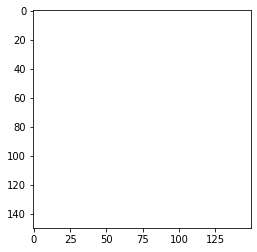

In [15]:
# Observando as images após a normalização
plt.imshow(images[3])

In [16]:
# Embaralhar os dados e separar novos conjuntos de  treinamento (80%), validação (10%) e teste (10%)
images, labels = shuffle(images, labels, random_state=10)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
#test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


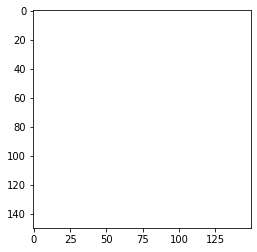

In [ ]:
plt.imshow(train_images[3])

In [17]:
n_train = train_labels.shape[0]
#n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Quantidade de imagens para treinamento: {}".format(n_train))
#print("Quantidade de imagens para validação: {}".format(n_val))
print("Quantidade de imagens para teste: {}".format(n_test))

print("Formato das imagens de treinamento: {}".format(train_images.shape))
print("Labels das imagens de treinamento: {}".format(train_labels.shape))
#print("Formato das imagens de validação: {}".format(val_images.shape))
#print("Labels das imagens de validação: {}".format(val_labels.shape))
print("Formato das imagens de teste: {}".format(test_images.shape))
print("Labels das imagens de teste: {}".format(test_labels.shape))


Quantidade de imagens para treinamento: 6918
Quantidade de imagens para teste: 1730
Formato das imagens de treinamento: (6918, 150, 150, 3)
Labels das imagens de treinamento: (6918,)
Formato das imagens de teste: (1730, 150, 150, 3)
Labels das imagens de teste: (1730,)


In [18]:
print(train_images.shape)
print(test_images.shape)
#print(val_images.shape)


(6918, 150, 150, 3)
(1730, 150, 150, 3)


In [19]:
_, train_counts = np.unique(train_labels, return_counts = True)
#_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

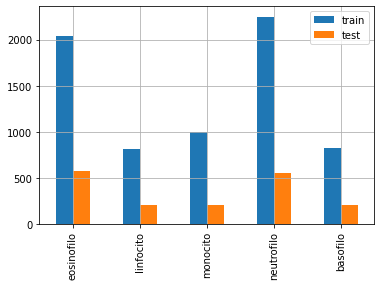

In [20]:
#pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()
pd.DataFrame({'train': train_counts, "test": test_counts}, index = class_names).plot.bar()
plt.grid()

plt.show()

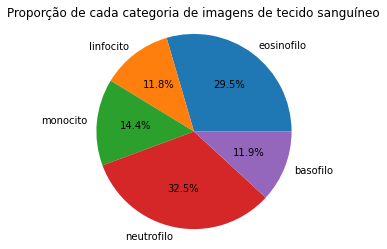

In [21]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporção de cada categoria de imagens de tecido sanguíneo')
plt.show()

In [22]:
train_images = train_images / 255.0 
#val_images = val_images / 255.0
test_images = test_images / 255.0

**Normalização dos dados**

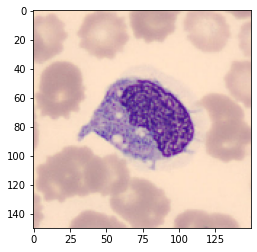

In [23]:
# Mais uma verificação da img após a normalização
plt.imshow(train_images[2000])

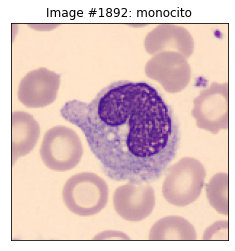

In [26]:
# Checagem com imagem aleatória
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image(class_names, train_images, train_labels)

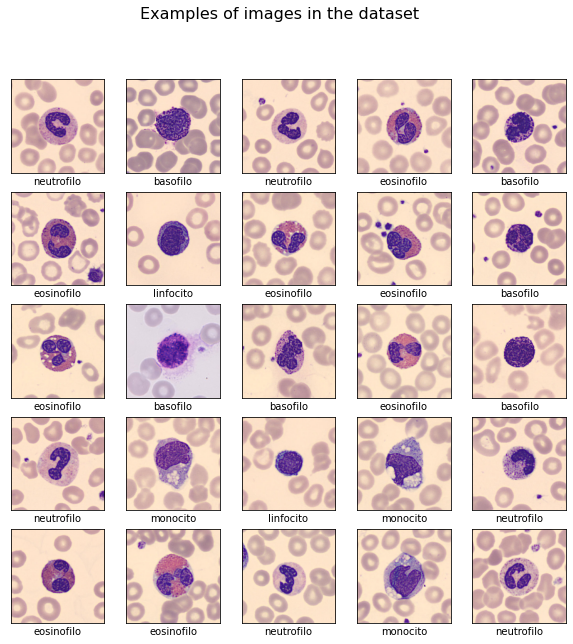

In [27]:
# Checagem com exemplos de imagens de cada categoria
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

## Xception Model

In [31]:
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
#from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file

In [32]:
def Xception():

	# # Determine proper input shape
	# input_shape = _obtain_input_shape(None, default_size=299, min_size=71, data_format='channels_last', include_top=False)

	img_input = Input(shape=(150,150,3))

	# Block 1
	x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = Conv2D(64, (3, 3), use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 2
	x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 2 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 3
	x = Activation('relu')(x)
	x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 3 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 4
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	# Block 5 - 12
	for i in range(8):
		residual = x

		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)

		x = layers.add([x, residual])

	residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 13
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 13 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	# Block 14
	x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# Block 14 part 2
	x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# Fully Connected Layer
	x = GlobalAveragePooling2D()(x)
	x = Dense(5, activation='softmax')(x)

	inputs = img_input

	# Create model
	model = Model(inputs, x, name='xception')

	# Download and cache the Xception weights file
	# weights_path = get_file('xception_weights.h5', WEIGHTS_PATH, cache_subdir='models')

	# load weights
	# model.load_weights(weights_path)

	return model

In [33]:
# Instanciando o modelo
model = Xception()

In [ ]:
model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()


# Callback
checkpoint = ModelCheckpoint(filepath='/content/model_20210804_epochs20_v2.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)


In [ ]:
# treinamento
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 20, 
    validation_data=(test_images, test_labels), 
    callbacks=[learning_rate_reduction])

## Construção e treino do modelo desenvolvido

In [ ]:
model = Sequential()
''' Minha Architectura '''
# Primeira bloco
model.add(Conv2D(32 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (150,150,3)))
model.add(Conv2D(32 , (3,3), padding = 'same' , activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Segunda camada concolucional
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Terceira camada concolucional
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))

# Quarta camada concolucional
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Quinta camada concolucional
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Camada (Fully Connected ) FC para classificar as features aprendidas
model.add(Flatten())
# model.add(Dense(units = 1024 , activation = 'relu'))
# model.add(Dropout(0.7))
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.3))

# Camada de saída
model.add(Dense(units = 5 , activation = 'softmax'))

# Compilação
model.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

# Callback
checkpoint = ModelCheckpoint(filepath='/content/model_20210804_epochs20.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)




## Treino

In [ ]:
# treinamento
history = model.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 20, 
    validation_data=(test_images, test_labels), 
    callbacks=[learning_rate_reduction])

## Avaliação - Resultados

In [ ]:
# Avaliação dp desempenh da CNN
def plotAccucaria(history):
    epochs = [i for i in range(20)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'bo-' , label = 'Acurácia de treinamento')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Acurária de validação')
    ax[0].set_title('Acurácia de treinamento e validação')
    ax[0].legend()
    ax[0].set_xlabel("Épocas")
    ax[0].set_ylabel("Acurácia")

    ax[1].plot(epochs , train_loss , 'bo-' , label = 'Perda no treinamento')
    ax[1].plot(epochs , val_loss , 'ro-' , label = 'Perda na validação')
    ax[1].set_title('Perdas no treinamento e validação')
    ax[1].legend()
    ax[1].set_xlabel("Épocas")
    ax[1].set_ylabel("Perdas")
    plt.show()

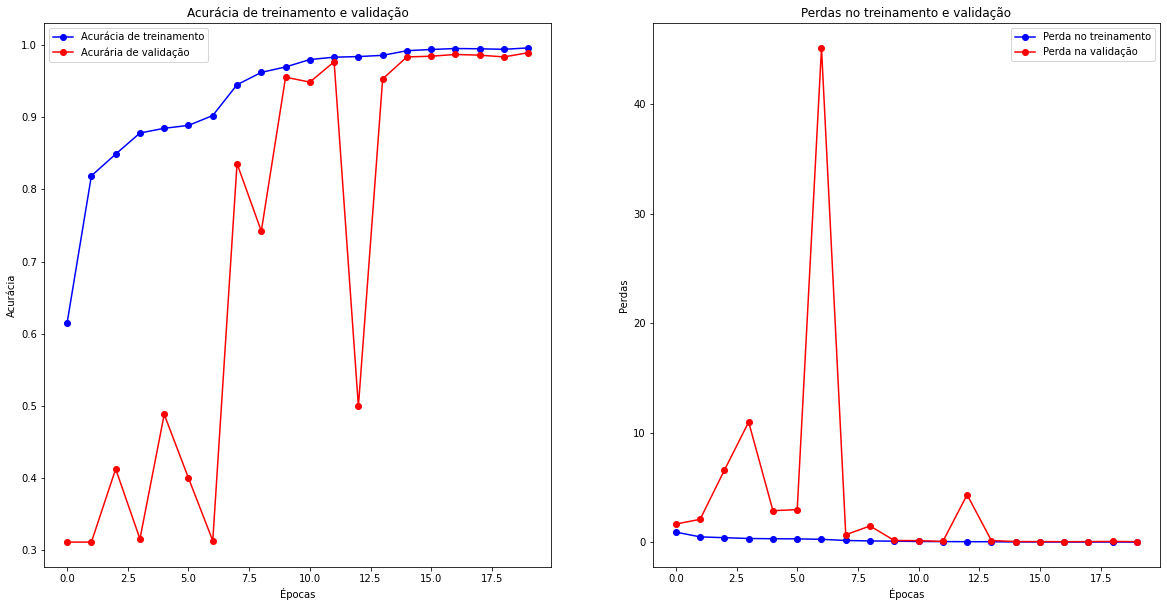

In [ ]:
# Usando a função plotAcuracia
plotAccucaria(history)


In [ ]:
# Resultados do treinamento da CNN
loss_model, acc_model = model.evaluate(test_images, test_labels)

print("Perda do modelo = ", loss_model)
print("Acurácia do modelo = ", acc_model*100, "%")

# print("Perda do modelo = ", results[0])
# print("Acurácia do modelo = ", results[1]*100, "%")

65/65 [==============================] - 1s 17ms/step - loss: 0.0517 - accuracy: 0.9898
Perda do modelo =  0.05170206353068352
Acurácia do modelo =  98.9805817604065 %


In [ ]:
# Salvar o modelo
#model.save('BloodModel_20210708.h5') #Acurácia do modelo: 22.93%
# Aumento do número de epochs de 10 para 20
#model.save('best_model_epoc_20.hdf5') #Acurácia do modelo: 74.19%
# Aumento do número de epochs de 10 para 50
model.save('model_20210804_epochs20_my_arc_acc90.98.hdf5') #Acurácia do modelo: 67.025%


In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([3, 3, 4, 0, 0, 1, 3, 0, 1, 3, 0, 1, 4, 3, 0])

In [ ]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['eosinófilo (Class 0)', 'linfócito (Class 1)', 'monócito (Class 2)', 'neutrófilo (Class 3)','basófilo (Class 4)']))

                      precision    recall  f1-score   support

eosinófilo (Class 0)       1.00      0.99      0.99       640
 linfócito (Class 1)       0.96      0.99      0.97       230
  monócito (Class 2)       0.99      0.97      0.98       267
neutrófilo (Class 3)       0.99      1.00      0.99       668
  basófilo (Class 4)       1.00      0.98      0.99       255

            accuracy                           0.99      2060
           macro avg       0.99      0.99      0.99      2060
        weighted avg       0.99      0.99      0.99      2060



In [ ]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3', '4'], columns = ['0', '1', '2', '3', '4'])
cm

,0,1,2,3,4
0,636,1,0,3,0
1,0,228,2,0,0
2,0,7,259,0,1
3,2,0,1,665,0
4,1,2,0,1,251


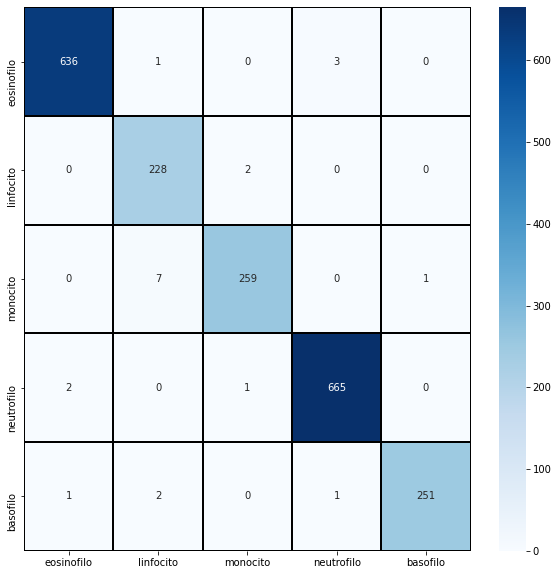

In [ ]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

# Gerando imagem da arquitetura

### Model plotting utilities

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

### VisualKeras

In [ ]:
!pip install visualkeras

In [ ]:
import visualkeras
from PIL import ImageFont

In [ ]:
font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf", 22)  # using comic sans is strictly prohibited!

In [ ]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, SeparableConv2D
from collections import defaultdict

color_map = defaultdict(dict)
color_map[SeparableConv2D]['fill'] = "gray"
color_map[Conv2D]['fill'] = "orange"
color_map[Dropout]['fill'] = "pink"
color_map[MaxPooling2D]['fill'] = "red"
color_map[Dense]['fill'] = "green"
color_map[Flatten]['fill'] = "green"




In [ ]:
visualkeras.layered_view(model,legend=True, font=font, color_map=color_map)

### Sequential model in Keras -> ASCII

In [ ]:
!pip install keras_sequential_ascii
import keras_sequential_ascii

In [ ]:
from keras_sequential_ascii import keras2ascii
keras2ascii(model)

### Neuron

In [ ]:
pip install netron

     |████████████████████████████████| 1.3 MB 11.7 MB/s 


In [ ]:
model.save('model_20210804_epochs20_acc.hdf5')

In [ ]:
import netron
netron.start('best_model_epoc_50.hdf5')

## Visualizando a accuracy nos dados de teste

In [ ]:
# Resultados do treinamento da CNN
loss_model, acc_model = model.evaluate(test_images, test_labels)

print("Perda do modelo = ", loss_model)
print("Acurácia do modelo = ", acc_model*100, "%")

# print("Perda do modelo = ", results[0])
# print("Acurácia do modelo = ", results[1]*100, "%")

52/52 [==============================] - 1s 17ms/step - loss: 0.0421 - accuracy: 0.9921
Perda do modelo =  0.04209888353943825
Acurácia do modelo =  99.21116232872009 %


## Verificação dos requisitos da máquina usada

Com o Colab Pro, você tem prioridade no acesso a nossas GPUs mais rápidas. Por exemplo, algumas vezes você terá GPUs T4 ou P100, quando a maioria dos usuários do Colab recebem uma GPU K80, mais lenta. É possível ver qual é a GPU atribuída a qualquer momento, executando a célula a seguir.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug  4 17:50:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# É possível ver quanta memória há disponível a qualquer momento, executando o seguinte código.

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.
